In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
train_df = pd.read_csv(
    "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
)


print(train_df.shape)
train_df.head()


(30227, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [4]:
df = (
    train_df
    .groupby("patientId")["Target"]
    .max()
    .reset_index()
    .rename(columns={"Target": "label"})
)

print("Raw rows:", len(train_df))
print("Unique images:", len(df))

Raw rows: 30227
Unique images: 26684


In [5]:
from sklearn.model_selection import train_test_split

# First split: Train vs Temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=42
)

# Second split: Val vs Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


Train: (18678, 2)
Val: (4003, 2)
Test: (4003, 2)


In [6]:
import os
import pydicom
import numpy as np
import random

TRAIN_IMG_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)

In [8]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
print("hi")

hi


In [9]:
class RSNADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pid = self.df.loc[idx, "patientId"]
        label = self.df.loc[idx, "label"]

        path = os.path.join(self.img_dir, pid + ".dcm")
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array

        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img = np.stack([img]*3, axis=-1).astype(np.uint8)

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)


In [10]:
BATCH_SIZE = 16

train_loader = DataLoader(
    RSNADataset(train_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    RSNADataset(val_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

test_loader = DataLoader(
    RSNADataset(test_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=1
)

model.to(device)


In [12]:
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)


In [13]:
import os
import cv2
import pydicom
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)


In [14]:
EPOCHS = 40
PATIENCE = 5
THRESHOLD = 0.5

history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": [],
    "train_prec": [], "val_prec": [],
    "train_f1": [], "val_f1": [],
    "train_auc": [], "val_auc": []
}

best_loss = float("inf")
patience_ctr = 0

for epoch in range(EPOCHS):
   
    model.train()
    t_loss, t_probs, t_labels = [], [], []

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        x = x.to(device)
        y = y.to(device).unsqueeze(1)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        t_loss.append(loss.item())
        t_probs.append(torch.sigmoid(logits).detach().cpu())
        t_labels.append(y.cpu())

    t_probs = torch.cat(t_probs).numpy()
    t_labels = torch.cat(t_labels).numpy()

   
    model.eval()
    v_loss, v_probs, v_labels = [], [], []

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            logits = model(x)
            loss = criterion(logits, y)

            v_loss.append(loss.item())
            v_probs.append(torch.sigmoid(logits).cpu())
            v_labels.append(y.cpu())

    v_probs = torch.cat(v_probs).numpy()
    v_labels = torch.cat(v_labels).numpy()

    def metrics(y_true, y_prob):
        y_pred = (y_prob > THRESHOLD).astype(int)
        return (
            accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred, zero_division=0),
            f1_score(y_true, y_pred, zero_division=0),
            roc_auc_score(y_true, y_prob)
        )

    t_acc, t_prec, t_f1, t_auc = metrics(t_labels, t_probs)
    v_acc, v_prec, v_f1, v_auc = metrics(v_labels, v_probs)

    history["train_loss"].append(np.mean(t_loss))
    history["val_loss"].append(np.mean(v_loss))
    history["train_acc"].append(t_acc)
    history["val_acc"].append(v_acc)
    history["train_prec"].append(t_prec)
    history["val_prec"].append(v_prec)
    history["train_f1"].append(t_f1)
    history["val_f1"].append(v_f1)
    history["train_auc"].append(t_auc)
    history["val_auc"].append(v_auc)

    print(
        f"Epoch {epoch+1} | "
        f"Train Loss {np.mean(t_loss):.5f} | "
        f"Val Loss {np.mean(v_loss):.5f} | "
        f"Val AUC {v_auc:.5f}"
    )

    if np.mean(v_loss) < best_loss:
        best_loss = np.mean(v_loss)
        patience_ctr = 0
        torch.save(model.state_dict(), "best_swin_stage1.pth")
    else:
        patience_ctr += 1
        if patience_ctr >= PATIENCE:
            print("🛑 Early stopping")
            break


Epoch 1 [Val]: 100%|██████████| 251/251 [00:57<00:00,  4.33it/s]


Epoch 1 | Train Loss 0.45722 | Val Loss 0.39628 | Val AUC 0.84350


Epoch 2 [Val]: 100%|██████████| 251/251 [00:36<00:00,  6.80it/s]


Epoch 2 | Train Loss 0.40633 | Val Loss 0.39603 | Val AUC 0.84323


Epoch 3 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.50it/s]


Epoch 3 | Train Loss 0.38720 | Val Loss 0.39892 | Val AUC 0.83441


Epoch 4 [Val]: 100%|██████████| 251/251 [00:37<00:00,  6.78it/s]


Epoch 4 | Train Loss 0.36800 | Val Loss 0.40985 | Val AUC 0.83215


Epoch 5 [Val]: 100%|██████████| 251/251 [00:53<00:00,  4.69it/s]


Epoch 5 | Train Loss 0.33301 | Val Loss 0.44227 | Val AUC 0.82898


Epoch 6 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.59it/s]


Epoch 6 | Train Loss 0.28796 | Val Loss 0.48462 | Val AUC 0.82536


Epoch 7 [Val]: 100%|██████████| 251/251 [00:37<00:00,  6.66it/s]

Epoch 7 | Train Loss 0.23149 | Val Loss 0.48384 | Val AUC 0.80880
🛑 Early stopping


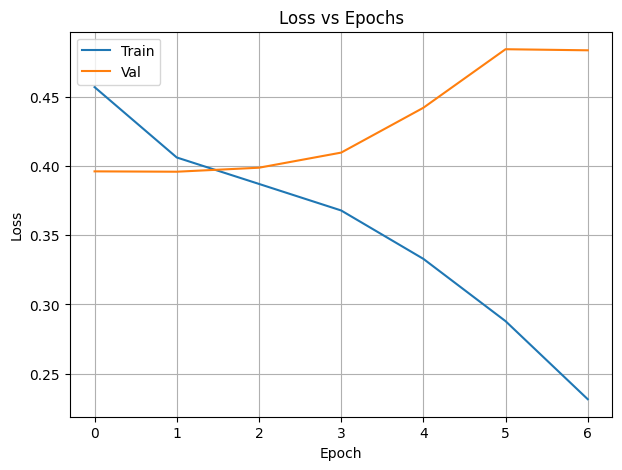

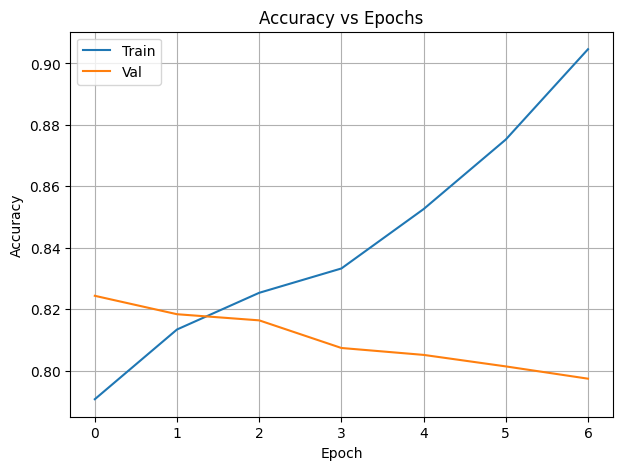

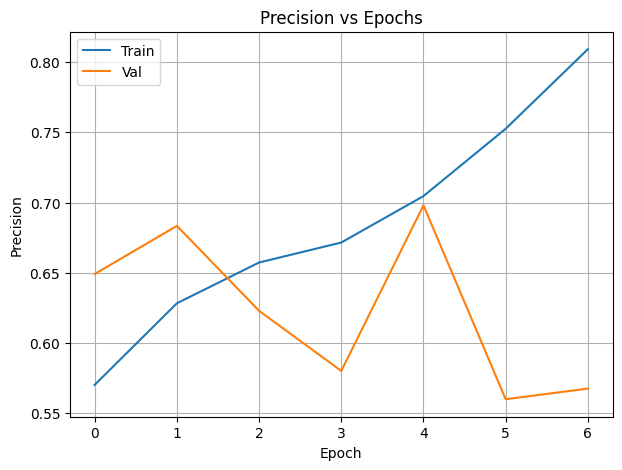

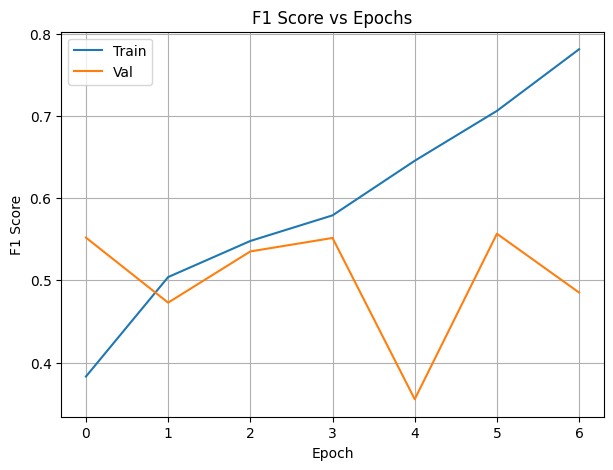

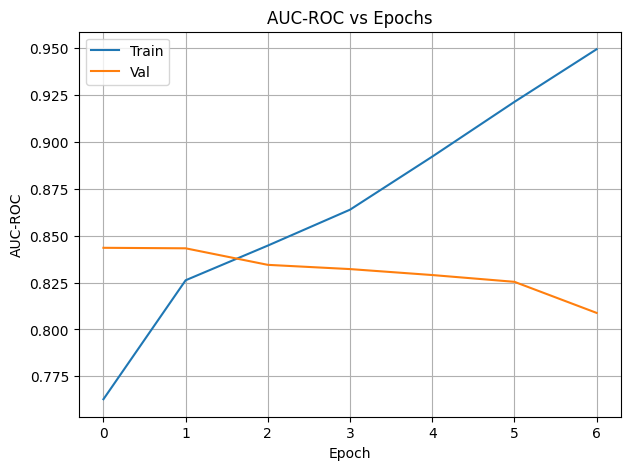

In [15]:
def plot_metric(name, ylabel):
    plt.figure(figsize=(7,5))
    plt.plot(history[f"train_{name}"], label="Train")
    plt.plot(history[f"val_{name}"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs Epochs")
    plt.legend()
    plt.grid()
    plt.show()

plot_metric("loss", "Loss")
plot_metric("acc", "Accuracy")
plot_metric("prec", "Precision")
plot_metric("f1", "F1 Score")
plot_metric("auc", "AUC-ROC")


In [16]:
model.load_state_dict(torch.load("best_swin_stage1.pth"))
model.eval()

probs, labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        probs.append(torch.sigmoid(logits).cpu())
        labels.append(y.unsqueeze(1))

probs = torch.cat(probs).numpy()
labels = torch.cat(labels).numpy()
preds = (probs > THRESHOLD).astype(int)


In [17]:
print(classification_report(labels, preds, digits=5))


              precision    recall  f1-score   support

         0.0    0.84200   0.95034   0.89290      3101
         1.0    0.69384   0.38692   0.49680       902

    accuracy                        0.82338      4003
   macro avg    0.76792   0.66863   0.69485      4003
weighted avg    0.80861   0.82338   0.80364      4003



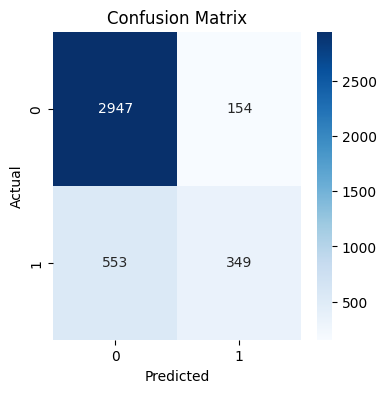

In [18]:
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


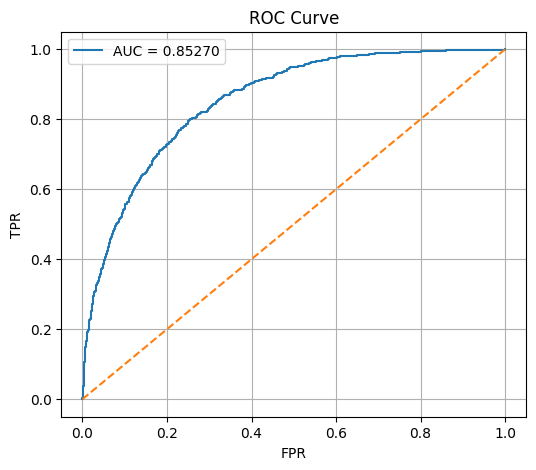

In [19]:
fpr, tpr, _ = roc_curve(labels, probs)
auc = roc_auc_score(labels, probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.5f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()
